# Real Estate Price Prediction: Developing Regression Models (Part 3)

Author: **Marcin Sikorski**<br>
Date: January, 2024

The final and third notebook containing price estimations. We will explore different regression models and determine the optimum regressor.

**Notebook Content:**
1. Preparing Dataset
2. Training & Evaluating Model
3. Hyperparameter Tuning
4. Feature Importance
5. Prediction Intervals
6. Conclusions

### 1. Preparing Dataset

We will import the previous data from EDA and convert it into NumPy arrays.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('kc_house_data.csv')

dataset = df.values # convert dataframe into array

# divide dataset into predictors and target
X = dataset[:, 1:]
y = dataset[:, 0]

print('Testing shape:', X.shape)
print('Target shape:', y.shape)

Testing shape: (21613, 19)
Target shape: (21613,)


The arrays will be transformed with the `MinMaxScaler` and divided into training, testing, and validation subsets.

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# rescale data
def rescale_data(a):
    min_max_scaler = MinMaxScaler()
    return min_max_scaler.fit_transform(a)

X_scale = rescale_data(X)

# divide arrays into: train, test & validation sets
X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X_scale, y, test_size=0.3, shuffle=True, random_state=32)
X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=0.5, shuffle=True, random_state=32)

print('Feature subsets shapes:')
print('Training:', X_train.shape)
print('Validation:', X_val.shape)
print('Testing:', X_test.shape)

print('\nTarget subsets shapes:')
print('Training:', y_train.shape)
print('Validation:', y_val.shape)
print('Testing:', y_test.shape)

Feature subsets shapes:
Training: (15129, 19)
Validation: (3242, 19)
Testing: (3242, 19)

Target subsets shapes:
Training: (15129,)
Validation: (3242,)
Testing: (3242,)


### 2. Training & Evaluating Model

At this stage, we will choose the best regressor. Nine algorithms will be provided and trained. For each model we will display achieved evaluation scores and determine the optimum.

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.model_selection import cross_val_score, KFold

eval_scores = [] # list for performance metrics

def train_regressors():
    polyn_reg = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
    lasso_reg = make_pipeline(PolynomialFeatures(degree=3), Lasso(alpha=10))
    ridge_reg = make_pipeline(PolynomialFeatures(degree=2), Ridge(alpha=0.1))
    elast_reg = make_pipeline(PolynomialFeatures(degree=3), ElasticNet(alpha=0.001))
    
    regressor_list = [RandomForestRegressor(),
                      DecisionTreeRegressor(),
                      CatBoostRegressor(loss_function='RMSE'),
                      XGBRegressor(),
                      LGBMRegressor(verbose=-1),
                      polyn_reg,
                      lasso_reg,
                      ridge_reg,
                      elast_reg]
    
    # 1. train listed regressors
    for model in regressor_list:
        if model.__class__.__name__ == 'LGBMRegressor':
            model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
            
        elif model.__class__.__name__ == 'CatBoostRegressor':
            model.fit(X_train, y_train, verbose=False)
            
        else:
            model.fit(X_train, y_train)
            
        predictions = model.predict(X_test) # make estimations
        
        # evaluation metrics for testing set
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        rmsle = np.sqrt(np.mean(np.power(np.log1p(predictions) - np.log1p(y_test), 2)))
        r2 = r2_score(y_test, predictions)
        adj_r2 = 1 - (1 - r2)*(len(predictions) - 1)/(len(predictions) - X_train.shape[1] - 1)
        vr = explained_variance_score(y_test, predictions)
        
        # cross-validation
        k_folds = KFold(n_splits=5, shuffle=False)
        if model.__class__.__name__ == 'CatBoostRegressor':
            cv_r2 = cross_val_score(model, X_train, y_train, cv=k_folds, scoring='r2', fit_params={'verbose': False}).mean()
            
        else:
            cv_r2 = cross_val_score(model, X_train, y_train, cv=k_folds, scoring='r2').mean()
        
        eval_scores.extend((rmse, rmsle, r2, adj_r2, vr, cv_r2))
    
    # 2. create list of score lists per model and display them in dataframe
    pandas_list = []

    for i in range(0, len(eval_scores)):
        if i % 6 == 0:
            pandas_list.append(eval_scores[i:i+6])
            
    header_list = ['RMSE', 'RMSLE', 'R2', 'Adjusted R2', 'Variance Regression', '5-Fold Cross-Validation']
    
    regressor_name = ['Random Forest', 'Decision Tree', 'CatBoost', 'XGBoost', 'LightGBM', 'Polynomial',
                      'Lasso', 'Ridge', 'ElasticNet']
            
    df_scores = pd.DataFrame.from_records(data=pandas_list, columns=header_list, index=regressor_name)
    
    return df_scores

train_regressors()

,RMSE,RMSLE,R2,Adjusted R2,Variance Regression,5-Fold Cross-Validation
Random Forest,105662.219517,0.167782,0.887026,0.886360,0.887034,0.886841
Decision Tree,146263.998610,0.248229,0.783523,0.782246,0.783550,0.772862
CatBoost,91614.488124,0.151137,0.915069,0.914568,0.915117,0.914245
XGBoost,98811.443612,0.159297,0.901201,0.900619,0.901210,0.895100
LightGBM,96765.460787,0.158616,0.905250,0.904692,0.905333,0.905447
Polynomial,116431.202603,0.196828,0.862825,0.862016,0.862906,0.863083
Lasso,110881.331638,0.183328,0.875590,0.874857,0.875642,0.874502
Ridge,116619.731407,0.195929,0.862380,0.861569,0.862467,0.862807
ElasticNet,119081.571572,0.196616,0.856508,0.855662,0.856575,0.859196


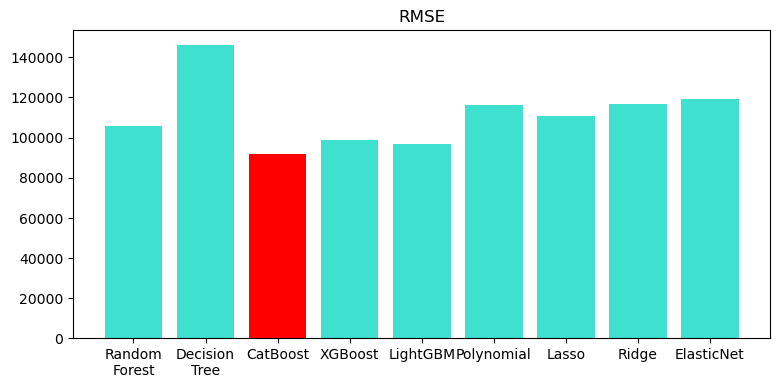

In [4]:
def plot_rmse():
    regressor_name = ['Random\nForest', 'Decision\nTree', 'CatBoost', 'XGBoost', 'LightGBM', 'Polynomial',
                      'Lasso', 'Ridge', 'ElasticNet']
    
    plt.figure(figsize=(9, 4))
    colors = ['red' if (bar == min(eval_scores[0::6])) else 'turquoise' for bar in list(eval_scores[0::6])]
    plt.bar(x=regressor_name, height=eval_scores[0::6], align='center', color=colors)
    plt.title('RMSE')
    plt.show()
    
plot_rmse()

> Machine learning techniques based on gradient boosting seem to perform the best among all chosen algorithms.

### 3. Hyperparameter Tuning

The categorical boosting regressor has the optimum performance within all models. We will determine the right combination of hyperparameters that maximizes the model performance with a grid search approach.

In [5]:
from sklearn.model_selection import GridSearchCV

def catboost_tuning():
    baseline = CatBoostRegressor(loss_function='RMSE')
    
    parameters = {'iterations': [100, 150, 200, 500, 1000],
                  'learning_rate': [0.03, 0.05, 0.1],
                  'depth': [2, 4, 6, 8],
                  'l2_leaf_reg': [0.1, 0.2, 0.5, 1]}
    
    grid_tuning = GridSearchCV(estimator=baseline, param_grid=parameters, cv=3, n_jobs=-1)
    grid_tuning.fit(X_train, y_train, verbose=False)
    
    cat_kwargs = grid_tuning.best_params_
    print('Best score across all searched params: {:.6f}'.format(grid_tuning.best_score_))
    print('Best score parameters all searched params:\n', cat_kwargs)
    
    global cb_model
    cb_model = CatBoostRegressor(loss_function='RMSE', **cat_kwargs)
    cb_model.fit(X_train, y_train, verbose=False)
    
    # testing subset
    predictions = cb_model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    rmsle = np.sqrt(np.mean(np.power(np.log1p(predictions) - np.log1p(y_test), 2))) # root mean squared logarithmic error
    r2 = r2_score(y_test, predictions)
    adj_r2 = 1 - (1 - r2)*(len(predictions) - 1)/(len(predictions) - X_train.shape[1] - 1)
    ev = explained_variance_score(y_test, predictions)
    k_folds = KFold(n_splits=5, shuffle=False)
    cv_r2 = cross_val_score(cb_model, X_test, y_test, cv=k_folds, scoring='r2', fit_params={'verbose': False}).mean()
    
    print('\nTesting performance:')
    print('RMSE: {:.1f}'.format(rmse))
    print('RMSLE: {:.4f}'.format(rmsle))
    print('R2: {:.4f}'.format(r2))
    print('Adjusted R2: {:.4f}'.format(adj_r2))
    print('Variance regression: {:.4f}'.format(ev))
    print('5-fold cross validation: {:.4f}'.format(cv_r2))
    
    # training subset
    predictions = cb_model.predict(X_train)
    
    rmse = np.sqrt(mean_squared_error(y_train, predictions))
    rmsle = np.sqrt(np.mean(np.power(np.log1p(predictions) - np.log1p(y_train), 2)))
    r2 = r2_score(y_train, predictions)
    adj_r2 = 1 - (1 - r2)*(len(predictions) - 1)/(len(predictions) - X_train.shape[1] - 1)
    ev = explained_variance_score(y_train, predictions)
    k_folds = KFold(n_splits=5, shuffle=False)
    cv_r2 = cross_val_score(cb_model, X_train, y_train, cv=k_folds, scoring='r2', fit_params={'verbose': False}).mean()

    print('\nTraining performance:')
    print('RMSE: {:.1f}'.format(rmse))
    print('RMSLE: {:.4f}'.format(rmsle))
    print('R2: {:.4f}'.format(r2))
    print('Adjusted R2: {:.4f}'.format(adj_r2))
    print('Variance regression: {:.4f}'.format(ev))
    print('5-fold cross validation: {:.4f}'.format(cv_r2))
    
catboost_tuning()   

Best score across all searched params: 0.915689
Best score parameters all searched params:
 {'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 0.5, 'learning_rate': 0.1}

Testing performance:
RMSE: 91404.4
RMSLE: 0.1508
R2: 0.9155
Adjusted R2: 0.9150
Variance regression: 0.9155
5-fold cross validation: 0.8912

Training performance:
RMSE: 50084.9
RMSLE: 0.1153
R2: 0.9753
Adjusted R2: 0.9753
Variance regression: 0.9753
5-fold cross validation: 0.9143


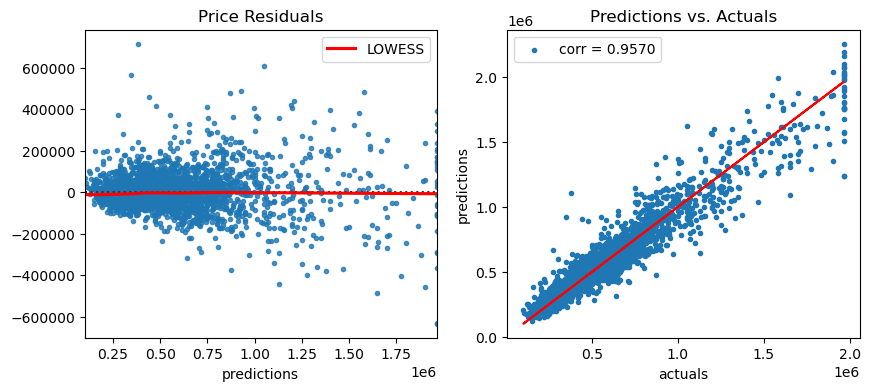

In [6]:
from seaborn import residplot

def plot_residuals():
    predictions = cb_model.predict(X_test)
    fig = plt.figure(figsize=(10, 4))
    
    # no clear pattern indicates that the linear approximation is appropriate
    plt.subplot(1, 2, 1)
    plot = residplot(x=y_test, y=predictions, lowess=True, line_kws={'color': 'red', 'label': 'LOWESS'},
                     scatter_kws={'marker': '.'})
    plot.set(title='Price Residuals', xlabel='predictions')
    plot.legend()
    
    plt.subplot(1, 2, 2)
    corr = np.corrcoef(y_test, predictions)[0, 1]
    plt.plot(y_test, y_test, color='red')
    plt.scatter(x=y_test, y=predictions, marker='.', label='corr = {:.4f}'.format(corr))
    plt.title('Predictions vs. Actuals')
    plt.xlabel('actuals')
    plt.ylabel('predictions')
    plt.legend()
    plt.show()
    
plot_residuals()

### 4. Feature Importance

We will plot the feature importance to check how useful the input features are at predicting a target variable in the CatBoost regressor.

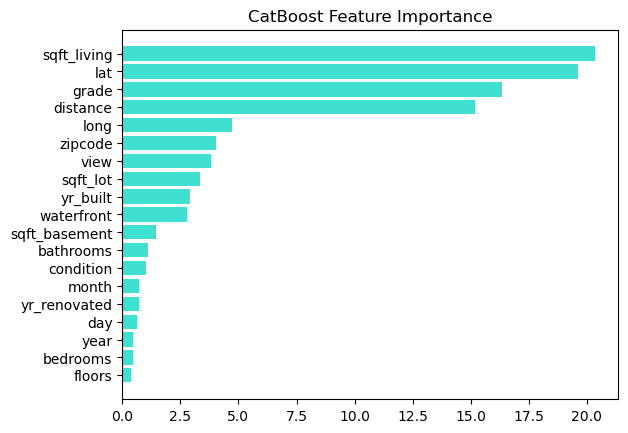

In [7]:
def plot_importance():
    keys = df.drop(['price'], axis=1).columns.tolist() # feature names
    values = cb_model.feature_importances_.tolist()
    
    dictionary = dict(zip(keys, values))
    scores = {k: v for k, v in sorted(dictionary.items(), key=lambda item: item[1])}
    
    plt.barh(y=list(scores.keys()), width=list(scores.values()), align='center', color='turquoise')
    plt.title('CatBoost Feature Importance')
    plt.show()

plot_importance()

Some of the features are worth discussing. First of all, it is obvious that the house square footage is the most important price factor. This should not come in surprise because a real estate is priced a certain amount of money per square foot. Therefore, the larger the house, the greater amount of money a customer needs to pay. Second most important factor is the location. Latitude is ranked the highest, but distance and longitude are also highly scored. Zipcode is also a discrete variable for location. The combination of these features determine the real estate location. We noticed previously that the most expensive flats tend to be based in the city's downtown. Nearby surrounding lakes, parks, convenient public transportation have a major impact for the price. The third important variable is the grade of the real estate. It is obvious and reasonable that a house in higher condition will attract more consumers, resulting in higher pricing.

### 5. Prediction Intervals

Prediction intervals describe the uncertainty for a single specific outcome and provide a way to quantify and communicate the uncertainty in a prediction. A prediction interval is different from a confidence interval. We will make some assumptions: the distributions of *x* and *y* and the prediction errors made by the model (residuals), have a Gaussian distribution. The prediction intervals can be calculated by multiplying the standard deviation of the predicted distribution with the number of standard deviations from the Gaussian distribution (e.g. 1.96 for a 95% interval).

Prediction interval: 179208.004
95% likelihood that the true value is between: 313258.117 and 671674.125
True value: 535000.0

95% likelihood that the true value is between: 237456.506 and 595872.515
True value: 400000.0

95% likelihood that the true value is between: 575242.681 and 933658.689
True value: 847000.0

95% likelihood that the true value is between: 1371701.606 and 1730117.614
True value: 1599950.0

95% likelihood that the true value is between: 1317461.547 and 1675877.555
True value: 1350000.0

95% likelihood that the true value is between: 687175.303 and 1045591.311
True value: 1075000.0


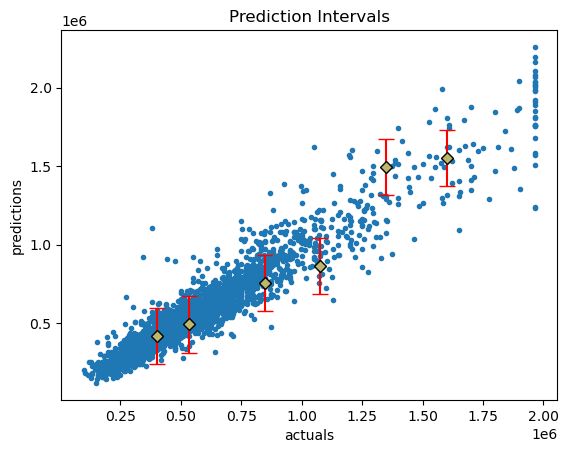

In [8]:
def plot_intervals(index_list):
    predictions = cb_model.predict(X_test)
    sum_errors = np.sum((y_test - predictions)**2)
    std = np.sqrt(1/(len(y_test) - 2) * sum_errors) # unbiased estimate of the standard deviation
    interval = 1.96 * std # significance level of 95%
    print('Prediction interval: {:.3f}'.format(interval))
    
    # 1. calculate examples
    for i in index_list:
        lower, upper = predictions[i] - interval, predictions[i] + interval
        
        print('95% likelihood that the true value is between: {:.3f} and {:.3f}'.format(lower, upper))
        if i == index_list[-1]:
            print('True value: {:.1f}'.format(y_test[i]))
        else:
            print('True value: {:.1f}\n'.format(y_test[i]))
    
    # 2. plot results
    plt.scatter(x=y_test, y=predictions, marker='.')
    for i in index_list:
        plt.errorbar(x=y_test[i], y=predictions[i], yerr=interval, color='black', mfc='darkkhaki', ecolor='red',
                     fmt='D', capsize=6, label='both limits (default)')
    plt.title('Prediction Intervals')
    plt.xlabel('actuals')
    plt.ylabel('predictions')
    plt.show()
    
# 'y_test' indices
plot_intervals(index_list=[0, 4, 600, 1290, 2533, 1819])

Categorical boosting model evaluation results for testing subset.

| RMSE    | RMSLE  | R<sup>2</sup> | Adjusted R<sup>2</sup> | Variance<br>Regression | 5-Fold Cross-<br>Validation |
|---------|--------|---------------|------------------------|------------------------|-----------------------------|
| 91404.4 | 0.1508 | 0.9155        | 0.9150                 | 0.9155                 | 0.8912                      |

### 6. Conclusions

In this notebook, the issue of house price prediction was explored using a case from King County in the US. Several models were utilized to fit the data. Their evaluation was derived with basic metrics: RMSE, *R<sup>2</sup>*, adjusted *R<sup>2</sup>*, etc. Among the chosen models, the CatBoost outperformed all of the other regressors and was selected as the final model to predict house prices.

Previously attached notebooks cover more dataset detail and characteristics using data visualization and statistical graphs - part 1, and a price estimation using an artificial neural network - part 2. Part 1 contains functions for cleaning, preparing, and transforming data.

From this case study, we obtained the following conslusions. Firstly, the categorical boosting serves as the optimum model for price prediction on this dataset. Secondly, we highlighted the most important factors that influence the house prices. These are mainly the real estate location (latitude, longitude, distance, etc.) and the surface of the house (square footage).

Although this study became a success, it still bears some slight drawbacks. This notebook does not cover any macroeconomic factors. Considering them would make the final model more accurate and return predictions closer to real-life situations. The model will work only for this specific market (King County). An additional reasearch or survey is probably needed for other regions that are not similar to the area of study.